In [38]:
import numpy as np 
import seaborn as sns
import scipy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt

## Steps
1. Find probability matrixes of Roll, GoToJail, Chance, Community, DoubleRule.
2. Matmul them
3. Find steady state probability using eigen

In [39]:
def create_matrix(matrix, mod_row):
    # init first row
    matrix[:,0] = mod_row
    for i, row in enumerate(range(40)):
        if i == 0:
            continue
        last_elem = mod_row.pop()
        mod_row = [last_elem] + mod_row
        matrix[:,i] = mod_row
        
    return matrix

#### Get Roll matrix
- every player rolls 2 6-sided die on their turn
- rolling 3 doubles in a row will send the player directly to "Jail"(covered in doubleruleMatrix)

In [40]:
rollProbabilities = [x / 36 for x in [0,1,2,3,4,5,6,5,4,3,2,1]]

In [41]:
rollProbabilities

[0.0,
 0.027777777777777776,
 0.05555555555555555,
 0.08333333333333333,
 0.1111111111111111,
 0.1388888888888889,
 0.16666666666666666,
 0.1388888888888889,
 0.1111111111111111,
 0.08333333333333333,
 0.05555555555555555,
 0.027777777777777776]

In [42]:
roll_matrix = np.zeros((40,40))
roll_row = [0]+rollProbabilities+[0]*27
rollMatrix = create_matrix(roll_matrix, roll_row)

In [43]:
rollMatrix

array([[0.        , 0.        , 0.        , ..., 0.05555556, 0.02777778,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.08333333, 0.05555556,
        0.02777778],
       [0.02777778, 0.        , 0.        , ..., 0.11111111, 0.08333333,
        0.05555556],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02777778, 0.        ,
        0.        ]])

In [44]:
print(rollMatrix[:, 1])

[0.         0.         0.         0.02777778 0.05555556 0.08333333
 0.11111111 0.13888889 0.16666667 0.13888889 0.11111111 0.08333333
 0.05555556 0.02777778 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


#### Landing on the "Go to Jail" Matrix:
- "Go to Jail" immediately sends you to "Jail"

In [45]:
gotojailMatrix = np.identity(40)
gotojailMatrix[30, 30] = 0
gotojailMatrix[10, 30] = 1

In [46]:
print(gotojailMatrix[:,30])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#### Chance cards Matrix: 7,22,36
Forward moving only, except for going to jail, or force to walk 3 steps back

**1/16 chance**
- Advance to Go
- Go to Jail
- Go to Illinois Avenue
- Go to St. Charles
- Go to Boardwalk
- Go back three spaces
- Go to nearest Utility (depends on which Chance location you are on)
- Go to Reading Railroad

**2/16 chance**
- Go to nearest Railroad - there are two of these cards

**6/16 chance**
- Stay where you are

In [47]:
chanceMatrix = np.identity(40)

chanceMatrix[:,7] = [0]*40
chanceMatrix[[0,10,24,11,39,5,4,12],7] = 1.0/16
chanceMatrix[15,7] = 2.0/16
chanceMatrix[7,7] = 6.0/16

chanceMatrix[:,22] = [0]*40
chanceMatrix[[0,10,24,11,39,5,19,28],22] = 1.0/16
chanceMatrix[25,22] = 2.0/16
chanceMatrix[22,22] = 6.0/16

chanceMatrix[:,36] = [0]*40
chanceMatrix[[0,10,24,11,39,33,12],36] = 1.0/16
chanceMatrix[5,36] = 3.0/16
chanceMatrix[36,36] = 6.0/16

In [48]:
chanceMatrix[:,7]

array([0.0625, 0.    , 0.    , 0.    , 0.0625, 0.0625, 0.    , 0.375 ,
       0.    , 0.    , 0.0625, 0.0625, 0.0625, 0.    , 0.    , 0.125 ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.0625, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.0625])

In [49]:
chanceMatrix[:,22]

array([0.0625, 0.    , 0.    , 0.    , 0.    , 0.0625, 0.    , 0.    ,
       0.    , 0.    , 0.0625, 0.0625, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.0625, 0.    , 0.    , 0.375 , 0.    ,
       0.0625, 0.125 , 0.    , 0.    , 0.0625, 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.0625])

In [50]:
chanceMatrix[:,36]

array([0.0625, 0.    , 0.    , 0.    , 0.    , 0.1875, 0.    , 0.    ,
       0.    , 0.    , 0.0625, 0.0625, 0.0625, 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.0625, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.0625, 0.    , 0.    , 0.375 , 0.    , 0.    , 0.0625])

#### Community Chest cards Matrix: 2, 17, 33

**1/16**
- Go to Go
- Go to Jail

**14/16**
- Stay where you are

In [51]:
communityMatrix = np.identity(40)

communityMatrix[[0,10],2] = 1.0/16
communityMatrix[2,2] = 14.0/16

communityMatrix[[0,10],17] = 1.0/16
communityMatrix[17,17] = 14.0/16

communityMatrix[[0,10],33] = 1.0/16
communityMatrix[33,33] = 14.0/16

In [52]:
communityMatrix[:, 2]

array([0.0625, 0.    , 0.875 , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.0625, 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ])

In [53]:
communityMatrix[:, 17]

array([0.0625, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.0625, 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.875 , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ])

In [54]:
communityMatrix[:, 33]

array([0.0625, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.0625, 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.875 , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ])

#### Double Rule (Deleted, not used)
- 648/649: chance of NOT rolling 3 doubles in a row(1/(6^3*3)) at every tile.
- 1/648: chance of getting sent to jail at every tile. 

-> remove the identity matrix!~

In [55]:
roll_double = 1.0/(6*6*6*3)
not_double = 1.0-roll_double
doubleruleMatrix = np.identity(40)*not_double

In [56]:
doubleruleMatrix[10, [range(40)]] = roll_double
doubleruleMatrix[10, 30] = 1
doubleruleMatrix[30, 30] = 0

doubleruleMatrix[10,10] = 1

#### Final Transition matrix


In [57]:
# https://jadhav-pritish.medium.com/solving-markov-chains-using-python-35cc79efddd7
def find_steady_state_probability(Matrix):
    # get vectors
    eigen_values, eigen_vectors = la.eig(Matrix)

    # steady state probability is eigen vector with eigen value 1
    eigen_val_index = [round(elem.real) for elem in eigen_values].index(1.0)

    # normalize the eigen vector
    return eigen_vectors[:, eigen_val_index] / sum(
        eigen_vectors[:, eigen_val_index]
    )

In [58]:
# combine the matrixes, and compute steady state probability
finalMatrix = np.matmul(np.matmul(np.matmul(communityMatrix, chanceMatrix), gotojailMatrix), rollMatrix)
steady_state_vec = find_steady_state_probability(finalMatrix).real
print(steady_state_vec)

[ 0.03113803  0.02152422  0.01899769  0.02185791  0.02350777  0.02993127
  0.02285359  0.00876027  0.02347011  0.02330647  0.0589642   0.02735991
  0.02627461  0.02385533  0.02467375  0.02918612  0.02776751  0.02571807
  0.02916517  0.03071024  0.02874826  0.02830354  0.01047697  0.02738577
  0.03187795  0.03063697  0.02706511  0.02679313  0.02810737  0.02591185
 -0.          0.02686592  0.02633846  0.0237657   0.0251047   0.02445896
  0.00871503  0.02202178  0.02193107  0.02646926]


In [59]:
nohouse_pd = pd.read_csv("financials/noHouse.csv")

In [60]:
# assigning 
nohouse_pd.color.fillna('none')

0       none
1      brown
2       none
3      brown
4       none
5       none
6       cyan
7       none
8       cyan
9       cyan
10      none
11      pink
12      none
13      pink
14      pink
15      none
16    orange
17      none
18    orange
19    orange
20      none
21       red
22      none
23       red
24       red
25      none
26    yellow
27    yellow
28      none
29    yellow
30      none
31     green
32     green
33      none
34     green
35      none
36      none
37      blue
38      none
39      blue
Name: color, dtype: object

In [61]:
steady_df = pd.DataFrame({'tile':range(0,40), 'steady_probability':steady_state_vec, 'color':nohouse_pd.color.fillna("none"), 'tile_name':nohouse_pd.name})

In [62]:
palette ={"brown": "C5", "cyan": "C9", "pink": "C6", "orange": "C1", "red": "C3", "yellow":"C8", "green":"C2", "blue":"C0", "none":"C7"}

Text(0.5, 1.0, 'Steady state probabilities of tiles')

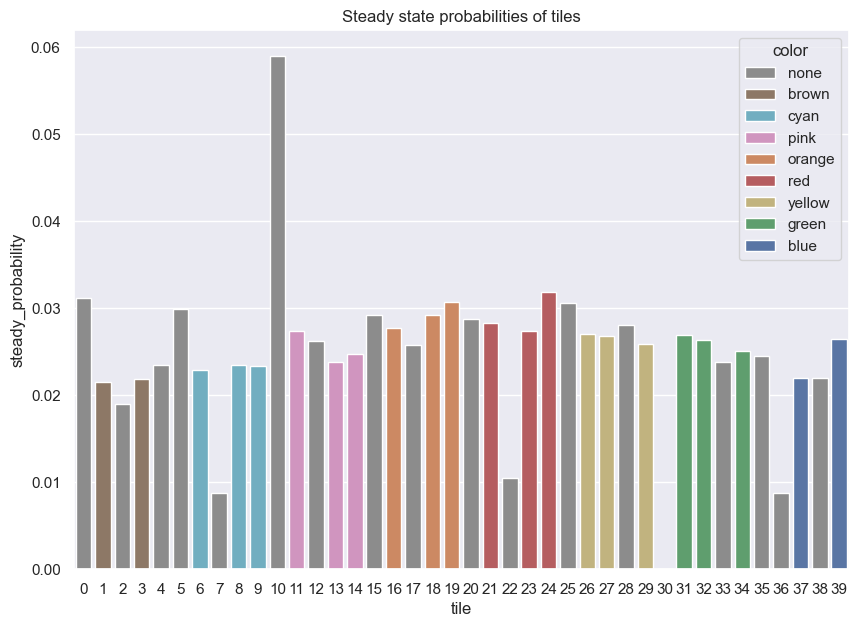

In [63]:
sns.set_theme(rc={"figure.figsize": (10, 7)})

sns.barplot(
    data= steady_df,
    x = 'tile',
    y= 'steady_probability',
    hue="color",
    palette=palette).set_title("Steady state probabilities of tiles")


In [64]:
steady_df.sort_values('steady_probability',ascending = False).head(10)


,tile,steady_probability,color,tile_name
10,10,0.058964,none,Jail
24,24,0.031878,red,Illinois Avenue
0,0,0.031138,none,Go
19,19,0.030710,orange,New York Avenue
25,25,0.030637,none,B. & O. Railroad
5,5,0.029931,none,Reading Railroad
15,15,0.029186,none,Pennsylvania Railroad
18,18,0.029165,orange,Tennessee Avenue
20,20,0.028748,none,Free parking
21,21,0.028304,red,Kentucky Avenue


In [65]:
steady_df.to_csv("steady_state_probi.csv", encoding="utf-8")